In [1]:
# %%
import torch
import matplotlib.pyplot as plt
from torch.distributions import Normal, Gamma, Categorical
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples  

# ─────────────────────────────────────────────────────────────────────────────
# Simulate Data
# ─────────────────────────────────────────────────────────────────────────────
torch.manual_seed(1010)

# True target: Mixture of two normals
weights = torch.tensor([0.6, 0.4])
means = torch.tensor([-2.0, 2.0])
stds = torch.tensor([0.5, 1.0])
component_dists = [Normal(means[i], stds[i]) for i in range(2)]
cat = Categorical(probs=weights)

def true_log_p_theta(theta):
    """Log-density of the mixture prior p(θ)."""
    terms = [torch.log(weights[i]) + component_dists[i].log_prob(theta) for i in range(2)]
    return torch.logsumexp(torch.stack(terms, dim=0), dim=0)

# Simulated η ~ Gamma(2,1)
N_MC = 1000
p_eta = 1
eta_dist = Gamma(concentration=2.0, rate=1.0)
eta_samples = eta_dist.sample((N_MC, p_eta))
#eta_samples = torch.ones(N_MC, p_eta)

# Dummy data D2 (not used in validation likelihood)
data_D2 = None

# ─────────────────────────────────────────────────────────────────────────────
# Define Likelihood (Validation: log p(y|θ,η) ≡ 0)
# ─────────────────────────────────────────────────────────────────────────────
def dummy_likelihood_log_prob_fn(theta, eta, data_D2):
    """In validation, likelihood is 1 ⇒ log-likelihood is 0."""
    return torch.zeros(theta.shape[0])

# ─────────────────────────────────────────────────────────────────────────────
# Initialize CutBayesFlow
# ─────────────────────────────────────────────────────────────────────────────
p_theta = 1
model = CutBayesFlow(
    prior_log_prob_fn=true_log_p_theta,
    likelihood_log_prob_fn=dummy_likelihood_log_prob_fn,
    eta_dim=p_eta,
    theta_dim=p_theta,
    num_layers=16,
    hidden_features=32,
    num_bins=20,
    tail_bound=10.0,
    use_residual_blocks=True,
    num_blocks=2
)

# ─────────────────────────────────────────────────────────────────────────────
# Train the model
# ─────────────────────────────────────────────────────────────────────────────
print("Training CutBayesFlow on validation simulation...")
loss_history = train_cut_bayes_flow(
    model,
    eta_samples,
    data_D2,
    epochs=1500,
    lr=5e-3,
    log_interval=200,  # configurable
    seed = 1010,
    verbose=True
)



Training CutBayesFlow on validation simulation...
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: -1356.766724 | LR: 5.00e-03
Step   200 | Loss: -1396.497070 | LR: 5.00e-03
Epoch 00328: reducing learning rate of group 0 to 2.5000e-03.
Step   400 | Loss: -1426.628296 | LR: 2.50e-03
Epoch 00453: reducing learning rate of group 0 to 1.2500e-03.
Step   600 | Loss: -1422.958496 | LR: 1.25e-03
Epoch 00643: reducing learning rate of group 0 to 6.2500e-04.
Step   800 | Loss: -1441.772461 | LR: 6.25e-04
Epoch 00884: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00985: reducing learning rate of group 0 to 1.5625e-04.
Step  1000 | Loss: -1423.928833 | LR: 1.56e-04
Epoch 01086: reducing learning rate of group 0 to 7.8125e-05.
Epoch 01187: reducing learning rate of group 0 to 3.9063e-05.
Step  1200 | Loss: -1450.699829 | LR: 3.91e-05
Epoch 01288: reducing learning rate of group 0 to 1.9531e-05.
Epoch 01389: reducing learning rate of group 0 to 9.7656e-06.
Step  1400 | Loss: -13

Text(0, 0.5, 'Loss')

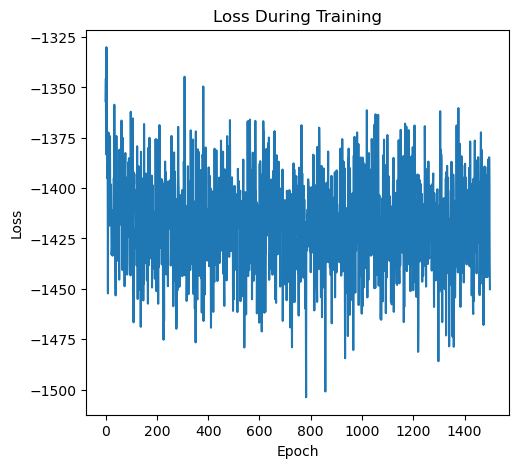

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot Loss and Compare Distributions
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")


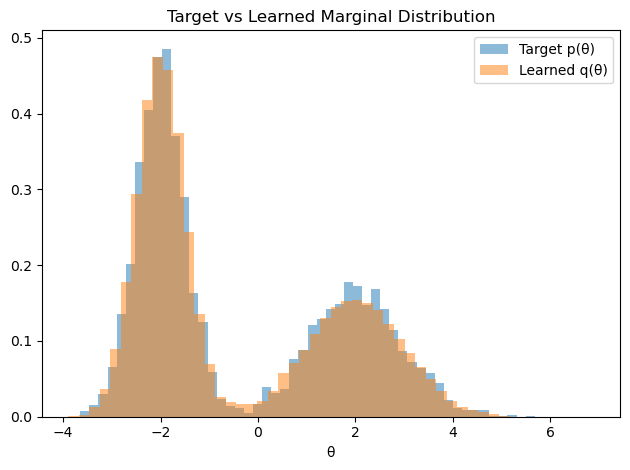

In [3]:
import numpy as np

n_samples = 5000
comp_idx = cat.sample((n_samples,))
theta_samples_p = means[comp_idx] + stds[comp_idx] * torch.randn(n_samples)

# Samples from learned marginal q(θ) ≈ E_η[q(θ|η)]
n_iterations = 5000
theta_samples_q = get_marginal_samples(model, eta_samples, n_iterations=n_iterations)

# Flatten and move to CPU for NumPy
theta_samples_p_flat = theta_samples_p.detach().cpu().numpy()
theta_samples_q_flat = theta_samples_q.detach().cpu().reshape(-1).numpy()

# Plot histograms
plt.hist(theta_samples_p_flat, bins=50, density=True, alpha=0.5, label="Target p(θ)")
plt.hist(theta_samples_q_flat, bins=50, density=True, alpha=0.5, label="Learned q(θ)")
plt.title("Target vs Learned Marginal Distribution")
plt.xlabel("θ")
plt.legend()

plt.tight_layout()
plt.show()

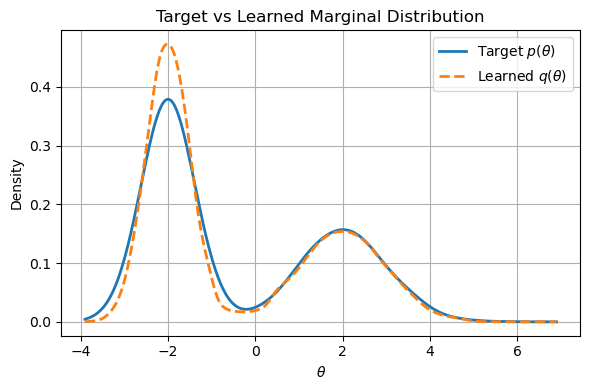

In [4]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Assuming theta_samples_p and theta_samples_q already exist
theta_samples_p_flat = theta_samples_p.detach().cpu().numpy()
theta_samples_q_flat = theta_samples_q.detach().cpu().reshape(-1).numpy()

# Compute kernel density estimates
kde_p = gaussian_kde(theta_samples_p_flat)
kde_q = gaussian_kde(theta_samples_q_flat)

# Define grid for θ
theta_grid = np.linspace(
    min(theta_samples_p_flat.min(), theta_samples_q_flat.min()),
    max(theta_samples_p_flat.max(), theta_samples_q_flat.max()),
    500
)

# Evaluate densities
density_p = kde_p(theta_grid)
density_q = kde_q(theta_grid)

# Plot density lines
plt.figure(figsize=(6, 4))
plt.plot(theta_grid, density_p, label="Target $p(\\theta)$", linewidth=2)
plt.plot(theta_grid, density_q, label="Learned $q(\\theta)$", linewidth=2, linestyle='--')
plt.title("Target vs Learned Marginal Distribution")
plt.xlabel("$\\theta$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
